<a href="https://colab.research.google.com/github/nannthd/project_AIEngineer/blob/main/vector_drug_ViTModel_Fine_Tune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/drug/data 50 class add_augment.zip'

In [ ]:
!unzip '/content/drive/MyDrive/drug/ViT_FT_model_v1.zip'

#image2vector ResNet50

##224*224

###50cls

In [ ]:
import zipfile
import os

# ตั้งชื่อไฟล์ ZIP และโฟลเดอร์ที่ต้องการแตกไฟล์
zip_filename = '/content/drive/MyDrive/drug/drug50cls.zip'
extract_folder = '/content/drug50cls_ResNet50'

# สร้างโฟลเดอร์สำหรับเก็บไฟล์ที่แตกออกมา
os.makedirs(extract_folder, exist_ok=True)

# เปิดไฟล์ ZIP และแตกไฟล์
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)
    print(f"Files extracted to {extract_folder}")

Files extracted to /content/drug50cls_ResNet50


###Cosine similarity

In [ ]:
!pip install tensorflow

In [ ]:
import pandas as pd
import numpy as np
import os
from sklearn.metrics.pairwise import cosine_similarity
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
from PIL import Image

# ใช้โมเดล ResNet50 ของ TensorFlow ในการทำ embedding
model = ResNet50(include_top=False, weights='imagenet', pooling='avg')

def image_embedding(path):
    img = Image.open(path)
    img = img.resize((224, 224))  # ปรับขนาดภาพให้เข้ากับ ResNet50
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    curr_df = pd.DataFrame(preds[0]).T
    return curr_df

def load_embeddings_from_csv(csv_folder):
    all_embeddings = {}
    for csv_file in os.listdir(csv_folder):
        if csv_file.endswith('.csv'):
            class_name = os.path.splitext(csv_file)[0]  # ใช้ชื่อไฟล์ CSV เป็นชื่อคลาส
            csv_path = os.path.join(csv_folder, csv_file)
            df = pd.read_csv(csv_path)
            # ดรอปคอลัมน์ ID และเก็บเฉพาะเวกเตอร์ของคลาส
            embeddings_no_id = df.drop(['ID'], axis=1)
            all_embeddings[class_name] = embeddings_no_id
    return all_embeddings

def find_most_similar_classes(new_image_path, all_embeddings):
    new_embedding = image_embedding(new_image_path)
    similarity_scores = {}

    for class_name, embeddings_df in all_embeddings.items():
        # คำนวณค่า similarity ระหว่าง embedding ของรูปภาพใหม่กับ embeddings ของคลาส
        similarity_score = cosine_similarity(new_embedding, embeddings_df)
        max_similarity_score = similarity_score.max()  # หา similarity ที่สูงที่สุดในคลาส
        similarity_scores[class_name] = max_similarity_score

    sorted_similarity = sorted(similarity_scores.items(), key=lambda x: x[1], reverse=True)
    top_5_similar_classes = sorted_similarity[:5]

    return top_5_similar_classes

# โหลด embedding จากโฟลเดอร์ที่เก็บไฟล์ CSV
csv_folder_path = '/content/drug50cls_ResNet50'
all_embeddings = load_embeddings_from_csv(csv_folder_path)

# รูปภาพที่ต้องการทดสอบ
new_image_path = '/content/1.jpg'

# ค้นหาคลาสที่มีความคล้ายกันที่สุด 5 อันดับ
similar_classes = find_most_similar_classes(new_image_path, all_embeddings)

# แสดงผลลัพธ์
print("Top 5 most similar classes:")
for rank, (class_name, similarity_score) in enumerate(similar_classes, start=1):
    print(f"{rank}. Class: {class_name}, Similarity Score: {similarity_score}")

1/1 [==============================] - 2s 2s/step
Top 5 most similar classes:
1. Class: Amlopine5mg, Similarity Score: 0.7161690444865032
2. Class: Lanzaar100mg, Similarity Score: 0.6803849533189887
3. Class: Amlopine10mg, Similarity Score: 0.6692816362653489
4. Class: BlopressPlus8mg, Similarity Score: 0.6641728463302811
5. Class: Betalol10mg, Similarity Score: 0.6504445370409421


#image2vector ViTModel

##224*224

###50cls

In [ ]:
import zipfile
import os

# ตั้งชื่อไฟล์ ZIP และโฟลเดอร์ที่ต้องการแตกไฟล์
zip_filename = '/content/drive/MyDrive/drug/drug50cls_ViTModel.zip'
extract_folder = '/content/drug50cls_ViTModel'

# สร้างโฟลเดอร์สำหรับเก็บไฟล์ที่แตกออกมา
os.makedirs(extract_folder, exist_ok=True)

# เปิดไฟล์ ZIP และแตกไฟล์
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)
    print(f"Files extracted to {extract_folder}")

Files extracted to /content/drug50cls_ViTModel


###Cosine similarity

In [ ]:
import pandas as pd
import numpy as np
import os
from sklearn.metrics.pairwise import cosine_similarity
from transformers import ViTImageProcessor, ViTModel
from PIL import Image
import torch

# ใช้โมเดล ViT ของ Hugging Face ในการทำ embedding
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')
model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')

# ย้ายโมเดลไปยัง GPU ถ้ามี
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def image_embedding(path):
    try:
        img = Image.open(path).convert('RGB').resize((224, 224))  # ปรับขนาดภาพให้เข้ากับ ViT
        inputs = processor(images=img, return_tensors="pt").to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        last_hidden_states = outputs.last_hidden_state
        avg_embedding = last_hidden_states.mean(dim=1).squeeze().cpu().detach().numpy()  # ค่าเฉลี่ยของ hidden states
        curr_df = pd.DataFrame(avg_embedding).T
        return curr_df
    except Exception as e:
        print(f"Error processing image {path}: {e}")
        return pd.DataFrame()

def load_embeddings_from_csv(csv_folder):
    all_embeddings = {}
    for csv_file in os.listdir(csv_folder):
        if csv_file.endswith('.csv'):
            class_name = os.path.splitext(csv_file)[0]  # ใช้ชื่อไฟล์ CSV เป็นชื่อคลาส
            csv_path = os.path.join(csv_folder, csv_file)
            df = pd.read_csv(csv_path)
            # ดรอปคอลัมน์ ID และเก็บเฉพาะเวกเตอร์ของคลาส
            embeddings_no_id = df.drop(['ID'], axis=1)
            all_embeddings[class_name] = embeddings_no_id
    return all_embeddings

def find_most_similar_classes(new_image_path, all_embeddings):
    new_embedding = image_embedding(new_image_path)
    similarity_scores = {}

    for class_name, embeddings_df in all_embeddings.items():
        # คำนวณค่า similarity ระหว่าง embedding ของรูปภาพใหม่กับ embeddings ของคลาส
        similarity_score = cosine_similarity(new_embedding, embeddings_df)
        max_similarity_score = similarity_score.max()  # หา similarity ที่สูงที่สุดในคลาส
        similarity_scores[class_name] = max_similarity_score

    sorted_similarity = sorted(similarity_scores.items(), key=lambda x: x[1], reverse=True)
    top_5_similar_classes = sorted_similarity[:5]

    return top_5_similar_classes

# โหลด embedding จากโฟลเดอร์ที่เก็บไฟล์ CSV
csv_folder_path = '/content/drug50cls_ViTModel'
all_embeddings = load_embeddings_from_csv(csv_folder_path)

# รูปภาพที่ต้องการทดสอบ
new_image_path = '/content/1.jpg'

# ค้นหาคลาสที่มีความคล้ายกันที่สุด 5 อันดับ
similar_classes = find_most_similar_classes(new_image_path, all_embeddings)

# แสดงผลลัพธ์
print("Top 5 most similar classes:")
for rank, (class_name, similarity_score) in enumerate(similar_classes, start=1):
    print(f"{rank}. Class: {class_name}, Similarity Score: {similarity_score}")

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Top 5 most similar classes:
1. Class: Prenolol50mg, Similarity Score: 0.49466794317903273
2. Class: MicardisPlus80_12.5mg, Similarity Score: 0.49443288263551155
3. Class: Micardis40mg, Similarity Score: 0.49117246129195574
4. Class: Amlopine10mg, Similarity Score: 0.48858949039492144
5. Class: Amlopine5mg, Similarity Score: 0.48842045271714224


#image2vector ViT_FT_model_v1

##224*224

###50cls

In [ ]:
# use VIT model to convert data
import pandas as pd
import numpy as np
import os
from transformers import ViTImageProcessor, ViTModel
from PIL import Image
import torch

# ใช้โมเดล ViT ของ Hugging Face ในการทำ embedding
# โหลดโมเดล ViT และ Processor
model_path = '/content/ViT_FT_model_v1'  # เปลี่ยนเป็น path ที่ถูกต้อง
model = ViTModel.from_pretrained(model_path)  # ใช้ ViTModel แทน ViTForImageClassification
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')

def image_embedding(path):
    img = Image.open(path).convert('RGB').resize((224, 224))  # ปรับขนาดภาพให้เข้ากับ ViT
    inputs = processor(images=img, return_tensors="pt")
    outputs = model(**inputs)
    last_hidden_states = outputs.last_hidden_state
    avg_embedding = last_hidden_states.mean(dim=1).squeeze().detach().numpy()  # ค่าเฉลี่ยของ hidden states

    curr_df = pd.DataFrame(avg_embedding).T
    return curr_df

def process_images_in_folder(folder_path, output_csv_path):
    pdEmbedded = pd.DataFrame()
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]

    for idx, image_file in enumerate(image_files):
        image_path = os.path.join(folder_path, image_file)
        embedded = image_embedding(image_path)
        embedded['ID'] = image_file  # ใช้ชื่อไฟล์เป็น ID
        pdEmbedded = pd.concat([pdEmbedded, embedded], ignore_index=True)

    # สร้างโฟลเดอร์สำหรับ output_csv_path
    output_folder = os.path.dirname(output_csv_path)
    os.makedirs(output_folder, exist_ok=True)

    # บันทึก DataFrame ลงในไฟล์ CSV
    pdEmbedded.to_csv(output_csv_path, index=False)

# ฟังก์ชันสำหรับการวนลูปโฟลเดอร์
def process_all_folders(base_folder_path, output_base_folder):
    subfolders = [f.path for f in os.scandir(base_folder_path) if f.is_dir()]

    for subfolder in subfolders:
        subfolder_name = os.path.basename(subfolder)
        output_csv_path = os.path.join(output_base_folder, f"{subfolder_name}.csv")
        process_images_in_folder(subfolder, output_csv_path)
        print(f"Embedding data for {subfolder_name} has been saved to {output_csv_path}")

# ตัวอย่างการใช้งาน
base_folder_path = "/content/data 50 class add_augment - Copy"
output_base_folder = "/content/drug50cls_ViT-FT-model-v1"
os.makedirs(output_base_folder, exist_ok=True)  # สร้างโฟลเดอร์หลักถ้ายังไม่มี

process_all_folders(base_folder_path, output_base_folder)

###Cosine similarity

In [ ]:
import pandas as pd
import numpy as np
import os
from sklearn.metrics.pairwise import cosine_similarity
from transformers import ViTImageProcessor, ViTModel
from PIL import Image
import torch

# ใช้โมเดล ViT ของ Hugging Face ในการทำ embedding
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')
model = ViTModel.from_pretrained('/content/ViT_FT_model_v1')

# ย้ายโมเดลไปยัง GPU ถ้ามี
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def image_embedding(path):
    try:
        img = Image.open(path).convert('RGB').resize((224, 224))  # ปรับขนาดภาพให้เข้ากับ ViT
        inputs = processor(images=img, return_tensors="pt").to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        last_hidden_states = outputs.last_hidden_state
        avg_embedding = last_hidden_states.mean(dim=1).squeeze().cpu().detach().numpy()  # ค่าเฉลี่ยของ hidden states
        curr_df = pd.DataFrame(avg_embedding).T
        return curr_df
    except Exception as e:
        print(f"Error processing image {path}: {e}")
        return pd.DataFrame()

def load_embeddings_from_csv(csv_folder):
    all_embeddings = {}
    for csv_file in os.listdir(csv_folder):
        if csv_file.endswith('.csv'):
            class_name = os.path.splitext(csv_file)[0]  # ใช้ชื่อไฟล์ CSV เป็นชื่อคลาส
            csv_path = os.path.join(csv_folder, csv_file)
            df = pd.read_csv(csv_path)
            # ดรอปคอลัมน์ ID และเก็บเฉพาะเวกเตอร์ของคลาส
            embeddings_no_id = df.drop(['ID'], axis=1)
            all_embeddings[class_name] = embeddings_no_id
    return all_embeddings

def find_most_similar_classes(new_image_path, all_embeddings):
    new_embedding = image_embedding(new_image_path)
    similarity_scores = {}

    for class_name, embeddings_df in all_embeddings.items():
        # คำนวณค่า similarity ระหว่าง embedding ของรูปภาพใหม่กับ embeddings ของคลาส
        similarity_score = cosine_similarity(new_embedding, embeddings_df)
        max_similarity_score = similarity_score.max()  # หา similarity ที่สูงที่สุดในคลาส
        similarity_scores[class_name] = max_similarity_score

    sorted_similarity = sorted(similarity_scores.items(), key=lambda x: x[1], reverse=True)
    top_5_similar_classes = sorted_similarity[:5]

    return top_5_similar_classes

# โหลด embedding จากโฟลเดอร์ที่เก็บไฟล์ CSV
csv_folder_path = '/content/drug50cls_ViT-FT-model-v1'
all_embeddings = load_embeddings_from_csv(csv_folder_path)

# รูปภาพที่ต้องการทดสอบ
new_image_path = '/content/1.jpg'

# ค้นหาคลาสที่มีความคล้ายกันที่สุด 5 อันดับ
similar_classes = find_most_similar_classes(new_image_path, all_embeddings)

# แสดงผลลัพธ์
print("Top 5 most similar classes:")
for rank, (class_name, similarity_score) in enumerate(similar_classes, start=1):
    print(f"{rank}. Class: {class_name}, Similarity Score: {similarity_score}")

Some weights of ViTModel were not initialized from the model checkpoint at /content/ViT_FT_model_v1 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Top 5 most similar classes:
1. Class: Amlopine5mg, Similarity Score: 0.8192938838663011
2. Class: Glyxambi25_5mg, Similarity Score: 0.293742445626238
3. Class: Novonorm2mg, Similarity Score: 0.272774406016006
4. Class: Novonorm1mg, Similarity Score: 0.26808631774506114
5. Class: Amlopine10mg, Similarity Score: 0.2589522246147995


###Test

In [ ]:
import pandas as pd
import numpy as np
import os
from sklearn.metrics.pairwise import cosine_similarity
from transformers import ViTImageProcessor, ViTModel
from PIL import Image
import torch
import matplotlib.pyplot as plt

# Use the ViT model from Hugging Face for embedding
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')
model = ViTModel.from_pretrained('/content/ViT_FT_model_v1')

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def image_embedding(path):
    try:
        img = Image.open(path).convert('RGB').resize((224, 224))  # Resize image to fit ViT
        inputs = processor(images=img, return_tensors="pt").to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        last_hidden_states = outputs.last_hidden_state
        avg_embedding = last_hidden_states.mean(dim=1).squeeze().cpu().detach().numpy()  # Average of hidden states
        curr_df = pd.DataFrame(avg_embedding).T
        return curr_df
    except Exception as e:
        print(f"Error processing image {path}: {e}")
        return pd.DataFrame()

def load_embeddings_from_csv(csv_folder):
    all_embeddings = {}
    for csv_file in os.listdir(csv_folder):
        if csv_file.endswith('.csv'):
            class_name = os.path.splitext(csv_file)[0]  # Use CSV file name as class name
            csv_path = os.path.join(csv_folder, csv_file)
            df = pd.read_csv(csv_path)
            # Drop the ID column and keep only the class vectors
            embeddings_no_id = df.drop(['ID'], axis=1)
            all_embeddings[class_name] = embeddings_no_id
    return all_embeddings

def find_most_similar_classes(new_embedding, all_embeddings):
    similarity_scores = {}

    for class_name, embeddings_df in all_embeddings.items():
        # Calculate similarity between the new image embedding and class embeddings
        similarity_score = cosine_similarity(new_embedding, embeddings_df)
        max_similarity_score = similarity_score.max()  # Find the highest similarity in the class
        similarity_scores[class_name] = max_similarity_score

    sorted_similarity = sorted(similarity_scores.items(), key=lambda x: x[1], reverse=True)
    top_5_similar_classes = sorted_similarity[:5]

    return top_5_similar_classes

def process_images_in_folder(image_folder, all_embeddings):
    for image_file in os.listdir(image_folder):
        image_path = os.path.join(image_folder, image_file)
        if os.path.isfile(image_path):
            new_embedding = image_embedding(image_path)
            similar_classes = find_most_similar_classes(new_embedding, all_embeddings)

            # Display the image
            img = Image.open(image_path)
            plt.imshow(img)
            plt.title(f"Image: {image_file}")
            plt.axis('off')
            plt.show()

            # Display similarity results
            print(f"Image: {image_file}")
            print("Top 5 most similar classes:")
            for rank, (class_name, similarity_score) in enumerate(similar_classes, start=1):
                print(f"{rank}. Class: {class_name}, Similarity Score: {similarity_score}")
            print()

# Load embeddings from the folder containing CSV files
csv_folder_path = '/content/drug50cls_ViT-FT-model-v1'
all_embeddings = load_embeddings_from_csv(csv_folder_path)

# Folder containing images to be tested
image_folder_path = '/content/drive/MyDrive/drug/Corp_test'

# Process each image in the folder and find similar classes
process_images_in_folder(image_folder_path, all_embeddings)

##640*640

###50cls

In [ ]:
# use VIT model to convert data
import pandas as pd
import numpy as np
import os
from transformers import ViTImageProcessor, ViTModel
from PIL import Image
import torch

# ใช้โมเดล ViT ของ Hugging Face ในการทำ embedding
# โหลดโมเดล ViT และ Processor
model_path = '/content/ViT_FT_model_v1'  # เปลี่ยนเป็น path ที่ถูกต้อง
model = ViTModel.from_pretrained(model_path)  # ใช้ ViTModel แทน ViTForImageClassification
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')

def image_embedding(path):
    img = Image.open(path).convert('RGB').resize((640, 640))  # ปรับขนาดภาพให้เข้ากับ ViT
    inputs = processor(images=img, return_tensors="pt")
    outputs = model(**inputs)
    last_hidden_states = outputs.last_hidden_state
    avg_embedding = last_hidden_states.mean(dim=1).squeeze().detach().numpy()  # ค่าเฉลี่ยของ hidden states

    curr_df = pd.DataFrame(avg_embedding).T
    return curr_df

def process_images_in_folder(folder_path, output_csv_path):
    pdEmbedded = pd.DataFrame()
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]

    for idx, image_file in enumerate(image_files):
        image_path = os.path.join(folder_path, image_file)
        embedded = image_embedding(image_path)
        embedded['ID'] = image_file  # ใช้ชื่อไฟล์เป็น ID
        pdEmbedded = pd.concat([pdEmbedded, embedded], ignore_index=True)

    # สร้างโฟลเดอร์สำหรับ output_csv_path
    output_folder = os.path.dirname(output_csv_path)
    os.makedirs(output_folder, exist_ok=True)

    # บันทึก DataFrame ลงในไฟล์ CSV
    pdEmbedded.to_csv(output_csv_path, index=False)

# ฟังก์ชันสำหรับการวนลูปโฟลเดอร์
def process_all_folders(base_folder_path, output_base_folder):
    subfolders = [f.path for f in os.scandir(base_folder_path) if f.is_dir()]

    for subfolder in subfolders:
        subfolder_name = os.path.basename(subfolder)
        output_csv_path = os.path.join(output_base_folder, f"{subfolder_name}.csv")
        process_images_in_folder(subfolder, output_csv_path)
        print(f"Embedding data for {subfolder_name} has been saved to {output_csv_path}")

# ตัวอย่างการใช้งาน
base_folder_path = "/content/data 50 class add_augment - Copy"
output_base_folder = "/content/drug50cls_ViT-FT-model-v1_640"
os.makedirs(output_base_folder, exist_ok=True)  # สร้างโฟลเดอร์หลักถ้ายังไม่มี

process_all_folders(base_folder_path, output_base_folder)

###Cosine similarity

In [12]:
import pandas as pd
import numpy as np
import os
from sklearn.metrics.pairwise import cosine_similarity
from transformers import ViTImageProcessor, ViTModel
from PIL import Image
import torch

# ใช้โมเดล ViT ของ Hugging Face ในการทำ embedding
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')
model = ViTModel.from_pretrained('/content/ViT_FT_model_v1')

# ย้ายโมเดลไปยัง GPU ถ้ามี
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def image_embedding(path):
    try:
        img = Image.open(path).convert('RGB').resize((640, 640))  # ปรับขนาดภาพให้เข้ากับ ViT
        inputs = processor(images=img, return_tensors="pt").to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        last_hidden_states = outputs.last_hidden_state
        avg_embedding = last_hidden_states.mean(dim=1).squeeze().cpu().detach().numpy()  # ค่าเฉลี่ยของ hidden states
        curr_df = pd.DataFrame(avg_embedding).T
        return curr_df
    except Exception as e:
        print(f"Error processing image {path}: {e}")
        return pd.DataFrame()

def load_embeddings_from_csv(csv_folder):
    all_embeddings = {}
    for csv_file in os.listdir(csv_folder):
        if csv_file.endswith('.csv'):
            class_name = os.path.splitext(csv_file)[0]  # ใช้ชื่อไฟล์ CSV เป็นชื่อคลาส
            csv_path = os.path.join(csv_folder, csv_file)
            df = pd.read_csv(csv_path)
            # ดรอปคอลัมน์ ID และเก็บเฉพาะเวกเตอร์ของคลาส
            embeddings_no_id = df.drop(['ID'], axis=1)
            all_embeddings[class_name] = embeddings_no_id
    return all_embeddings

def find_most_similar_classes(new_image_path, all_embeddings):
    new_embedding = image_embedding(new_image_path)
    similarity_scores = {}

    for class_name, embeddings_df in all_embeddings.items():
        # คำนวณค่า similarity ระหว่าง embedding ของรูปภาพใหม่กับ embeddings ของคลาส
        similarity_score = cosine_similarity(new_embedding, embeddings_df)
        max_similarity_score = similarity_score.max()  # หา similarity ที่สูงที่สุดในคลาส
        similarity_scores[class_name] = max_similarity_score

    sorted_similarity = sorted(similarity_scores.items(), key=lambda x: x[1], reverse=True)
    top_5_similar_classes = sorted_similarity[:5]

    return top_5_similar_classes

# โหลด embedding จากโฟลเดอร์ที่เก็บไฟล์ CSV
csv_folder_path = '/content/drug50cls_ViT-FT-model-v1_640'
all_embeddings = load_embeddings_from_csv(csv_folder_path)

# รูปภาพที่ต้องการทดสอบ
new_image_path = '/content/D2.jpg'

# ค้นหาคลาสที่มีความคล้ายกันที่สุด 5 อันดับ
similar_classes = find_most_similar_classes(new_image_path, all_embeddings)

# แสดงผลลัพธ์
print("Top 5 most similar classes:")
for rank, (class_name, similarity_score) in enumerate(similar_classes, start=1):
    print(f"{rank}. Class: {class_name}, Similarity Score: {similarity_score}")

Some weights of ViTModel were not initialized from the model checkpoint at /content/ViT_FT_model_v1 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Top 5 most similar classes:
1. Class: Daonil5mg, Similarity Score: 0.9406561931085347
2. Class: Gliparil2mg, Similarity Score: 0.3050581714279262
3. Class: Januvia100mg, Similarity Score: 0.3031118316351345
4. Class: Caduet5_10mg, Similarity Score: 0.27492118109947217
5. Class: Novonorm1mg, Similarity Score: 0.2703797349854351


###Test

Some weights of ViTModel were not initialized from the model checkpoint at /content/ViT_FT_model_v1 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


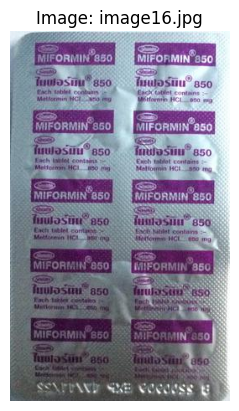

Image: image16.jpg
Top 5 most similar classes:
1. Class: Betalol40mg, Similarity Score: 0.628057222649931
2. Class: Caduet5_10mg, Similarity Score: 0.5347369703460534
3. Class: Prenolol50mg, Similarity Score: 0.5032744502818898
4. Class: Daonil5mg, Similarity Score: 0.32986097287459
5. Class: MicardisPlus80_12.5mg, Similarity Score: 0.3161500219952528



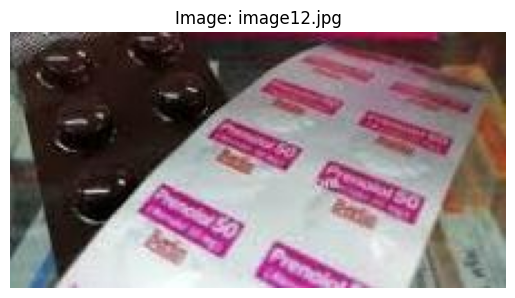

Image: image12.jpg
Top 5 most similar classes:
1. Class: Prenolol50mg, Similarity Score: 0.8161262842883499
2. Class: Betalol40mg, Similarity Score: 0.31103631849678776
3. Class: Caduet5_10mg, Similarity Score: 0.2856731711078764
4. Class: Daonil5mg, Similarity Score: 0.2751010771739422
5. Class: Januvia100mg, Similarity Score: 0.24013428354565625



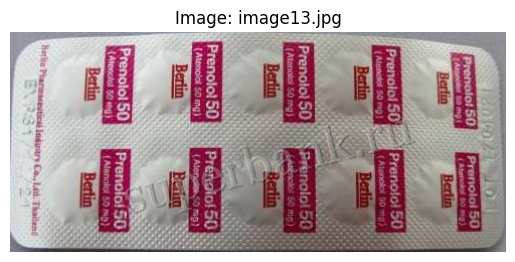

Image: image13.jpg
Top 5 most similar classes:
1. Class: Prenolol50mg, Similarity Score: 0.8301741105627689
2. Class: Betalol40mg, Similarity Score: 0.5250748317255906
3. Class: BlopressPlus16mg, Similarity Score: 0.40114235774051404
4. Class: Diovan160mg, Similarity Score: 0.3937880726160624
5. Class: Lercadip20mg, Similarity Score: 0.38132209016427254



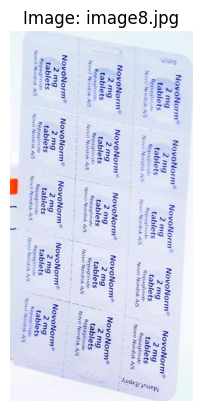

Image: image8.jpg
Top 5 most similar classes:
1. Class: Novonorm2mg, Similarity Score: 0.6195759903636002
2. Class: BlopressPlus8mg, Similarity Score: 0.5998823971348417
3. Class: Novonorm1mg, Similarity Score: 0.5951953011899787
4. Class: Forxiga10mg, Similarity Score: 0.542216116015105
5. Class: Diovan80mg, Similarity Score: 0.5255890094322812



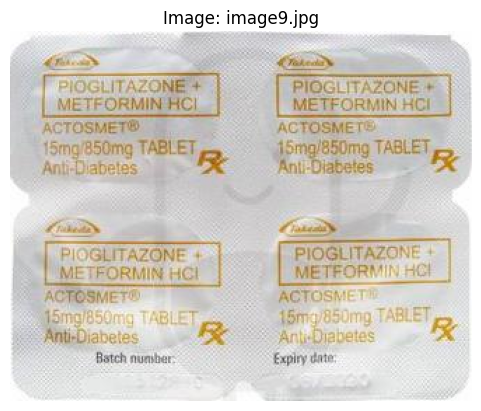

Image: image9.jpg
Top 5 most similar classes:
1. Class: Oseni25_15mg, Similarity Score: 0.9108968776133902
2. Class: Tanzaril50mg, Similarity Score: 0.24138450166840036
3. Class: Jardiance10mg, Similarity Score: 0.22653071538046315
4. Class: BlopressPlus16mg, Similarity Score: 0.21820447098321216
5. Class: Amlopine5mg, Similarity Score: 0.20858039991159846



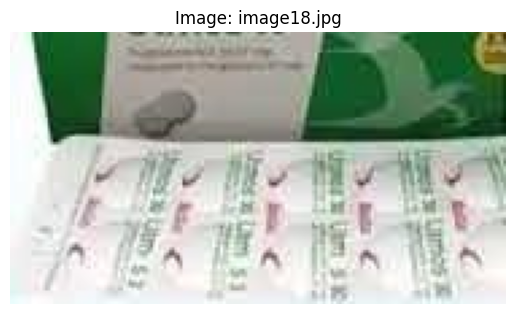

Image: image18.jpg
Top 5 most similar classes:
1. Class: Utmos30mg, Similarity Score: 0.48145725858309435
2. Class: Betalol10mg, Similarity Score: 0.4358739518579414
3. Class: Zanidip10mg, Similarity Score: 0.3846590574747206
4. Class: Madiplot20mg, Similarity Score: 0.33342724941732305
5. Class: Minidiab5mg, Similarity Score: 0.2773361384009198



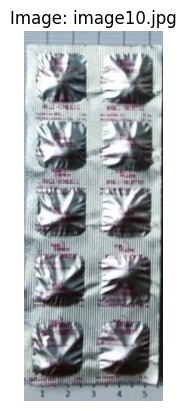

Image: image10.jpg
Top 5 most similar classes:
1. Class: Poli_uretic, Similarity Score: 0.4591357165849921
2. Class: Anapril5mg, Similarity Score: 0.4135039765123198
3. Class: Blopress16mg, Similarity Score: 0.32397943728373346
4. Class: Glucophage500mg, Similarity Score: 0.28500942900483517
5. Class: Madiplot10mg, Similarity Score: 0.27136880278532627



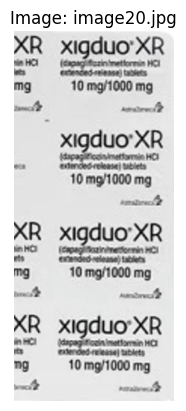

Image: image20.jpg
Top 5 most similar classes:
1. Class: XigduoXR10_1000mg, Similarity Score: 0.8759752457544706
2. Class: Forxiga10mg, Similarity Score: 0.31347903461825993
3. Class: Januvia100mg, Similarity Score: 0.28698815098319674
4. Class: Galvus50mg, Similarity Score: 0.2551177739173458
5. Class: Blopress8mg, Similarity Score: 0.2073596173310872



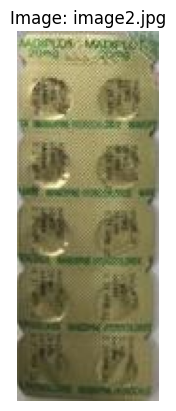

Image: image2.jpg
Top 5 most similar classes:
1. Class: Madiplot20mg, Similarity Score: 0.9296121419110418
2. Class: Madiplot10mg, Similarity Score: 0.3852668611838074
3. Class: JardianceDuo12.5_1000mg, Similarity Score: 0.2730150931340143
4. Class: Diovan80mg, Similarity Score: 0.2702228550042346
5. Class: Gliparil2mg, Similarity Score: 0.2436470869301126



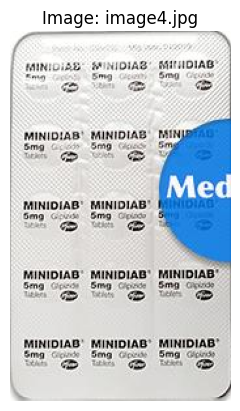

Image: image4.jpg
Top 5 most similar classes:
1. Class: Forxiga10mg, Similarity Score: 0.610469771430739
2. Class: Galvus50mg, Similarity Score: 0.5017064946506153
3. Class: Minidiab5mg, Similarity Score: 0.479397135069329
4. Class: Diovan80mg, Similarity Score: 0.46245553852601967
5. Class: BlopressPlus8mg, Similarity Score: 0.4471615140485975



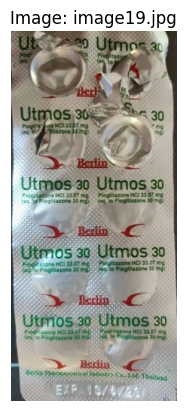

Image: image19.jpg
Top 5 most similar classes:
1. Class: Utmos30mg, Similarity Score: 0.8842622199209841
2. Class: Madiplot20mg, Similarity Score: 0.3037293014123806
3. Class: BlopressPlus16mg, Similarity Score: 0.24445649113464013
4. Class: Betalol10mg, Similarity Score: 0.23220454843418156
5. Class: Lercadip20mg, Similarity Score: 0.1885920646091774



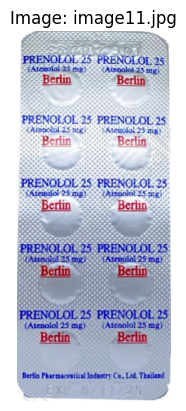

Image: image11.jpg
Top 5 most similar classes:
1. Class: Prenolol25mg, Similarity Score: 0.9571536158587339
2. Class: Amlopine10mg, Similarity Score: 0.3620900284170855
3. Class: Betalol10mg, Similarity Score: 0.2535026015645307
4. Class: Amlopine5mg, Similarity Score: 0.2517860213951444
5. Class: GalvusMet50_1000mg, Similarity Score: 0.2261724073566156



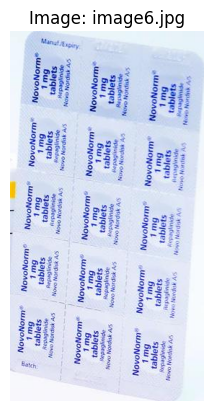

Image: image6.jpg
Top 5 most similar classes:
1. Class: Novonorm2mg, Similarity Score: 0.6703812380274591
2. Class: BlopressPlus8mg, Similarity Score: 0.6509854461967015
3. Class: Novonorm1mg, Similarity Score: 0.6024029325219477
4. Class: Diovan80mg, Similarity Score: 0.4709273945247912
5. Class: Forxiga10mg, Similarity Score: 0.38288698818198247



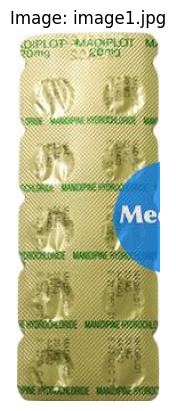

Image: image1.jpg
Top 5 most similar classes:
1. Class: Madiplot20mg, Similarity Score: 0.9228057811494343
2. Class: Madiplot10mg, Similarity Score: 0.41766129105634187
3. Class: Blopress8mg, Similarity Score: 0.21314476966574109
4. Class: Anapril5mg, Similarity Score: 0.2088673567456473
5. Class: Betalol40mg, Similarity Score: 0.20144873823702536



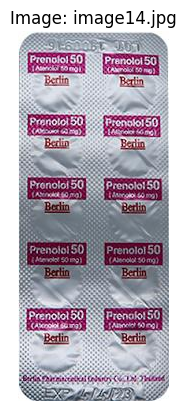

Image: image14.jpg
Top 5 most similar classes:
1. Class: Prenolol50mg, Similarity Score: 0.8794066344229894
2. Class: Betalol40mg, Similarity Score: 0.4075706548688283
3. Class: GalvusMet50_1000mg, Similarity Score: 0.2818397409055738
4. Class: Prenolol100mg, Similarity Score: 0.25873832832441884
5. Class: Lercadip20mg, Similarity Score: 0.25843379691901763



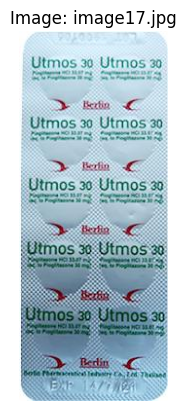

Image: image17.jpg
Top 5 most similar classes:
1. Class: Utmos30mg, Similarity Score: 0.8869553869881756
2. Class: BlopressPlus16mg, Similarity Score: 0.24032972859718216
3. Class: Betalol10mg, Similarity Score: 0.23831250280162247
4. Class: Lercadip20mg, Similarity Score: 0.23129442306370002
5. Class: Diovan160mg, Similarity Score: 0.18046750978872933



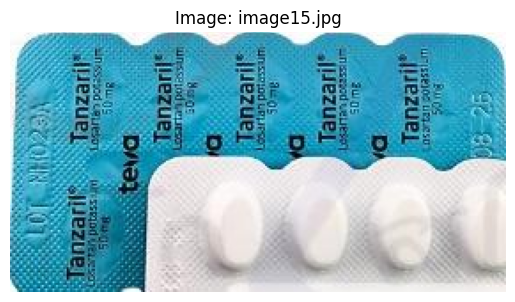

Image: image15.jpg
Top 5 most similar classes:
1. Class: Tanzaril50mg, Similarity Score: 0.6988204165242476
2. Class: Gliclazide80mg, Similarity Score: 0.37245815950725936
3. Class: MetoprololStada100mg, Similarity Score: 0.3540692265684393
4. Class: Minidiab5mg, Similarity Score: 0.3451731493311617
5. Class: Lanzaar100mg, Similarity Score: 0.3214626246209298



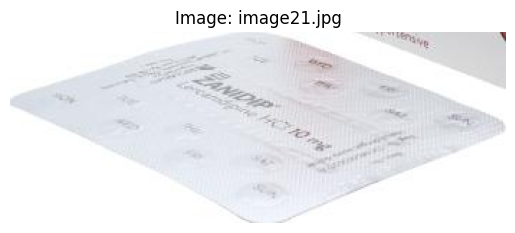

Image: image21.jpg
Top 5 most similar classes:
1. Class: Forxiga10mg, Similarity Score: 0.540165307337697
2. Class: Jardiance10mg, Similarity Score: 0.46375085521552417
3. Class: Gliclazide80mg, Similarity Score: 0.44368104573927253
4. Class: Blopress8mg, Similarity Score: 0.4123598993208938
5. Class: Betalol10mg, Similarity Score: 0.3986084241546149



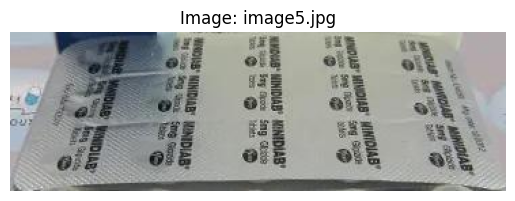

Image: image5.jpg
Top 5 most similar classes:
1. Class: Galvus50mg, Similarity Score: 0.6910019337871945
2. Class: Diovan80mg, Similarity Score: 0.6829082553551639
3. Class: Minidiab5mg, Similarity Score: 0.5795057909825388
4. Class: Januvia100mg, Similarity Score: 0.5773860165322047
5. Class: BlopressPlus8mg, Similarity Score: 0.5312428888821602



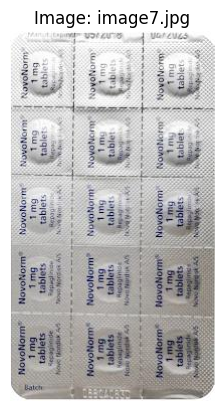

Image: image7.jpg
Top 5 most similar classes:
1. Class: Novonorm1mg, Similarity Score: 0.9419325156307774
2. Class: Novonorm2mg, Similarity Score: 0.9150684570721807
3. Class: Forxiga10mg, Similarity Score: 0.43670179922985963
4. Class: Diovan80mg, Similarity Score: 0.42950822753976386
5. Class: BlopressPlus8mg, Similarity Score: 0.4207257205739081



In [10]:
import pandas as pd
import numpy as np
import os
from sklearn.metrics.pairwise import cosine_similarity
from transformers import ViTImageProcessor, ViTModel
from PIL import Image
import torch
import matplotlib.pyplot as plt

# Use the ViT model from Hugging Face for embedding
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')
model = ViTModel.from_pretrained('/content/ViT_FT_model_v1')

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def image_embedding(path):
    try:
        img = Image.open(path).convert('RGB').resize((640, 640))  # Resize image to fit ViT
        inputs = processor(images=img, return_tensors="pt").to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        last_hidden_states = outputs.last_hidden_state
        avg_embedding = last_hidden_states.mean(dim=1).squeeze().cpu().detach().numpy()  # Average of hidden states
        curr_df = pd.DataFrame(avg_embedding).T
        return curr_df
    except Exception as e:
        print(f"Error processing image {path}: {e}")
        return pd.DataFrame()

def load_embeddings_from_csv(csv_folder):
    all_embeddings = {}
    for csv_file in os.listdir(csv_folder):
        if csv_file.endswith('.csv'):
            class_name = os.path.splitext(csv_file)[0]  # Use CSV file name as class name
            csv_path = os.path.join(csv_folder, csv_file)
            df = pd.read_csv(csv_path)
            # Drop the ID column and keep only the class vectors
            embeddings_no_id = df.drop(['ID'], axis=1)
            all_embeddings[class_name] = embeddings_no_id
    return all_embeddings

def find_most_similar_classes(new_embedding, all_embeddings):
    similarity_scores = {}

    for class_name, embeddings_df in all_embeddings.items():
        # Calculate similarity between the new image embedding and class embeddings
        similarity_score = cosine_similarity(new_embedding, embeddings_df)
        max_similarity_score = similarity_score.max()  # Find the highest similarity in the class
        similarity_scores[class_name] = max_similarity_score

    sorted_similarity = sorted(similarity_scores.items(), key=lambda x: x[1], reverse=True)
    top_5_similar_classes = sorted_similarity[:5]

    return top_5_similar_classes

def process_images_in_folder(image_folder, all_embeddings):
    for image_file in os.listdir(image_folder):
        image_path = os.path.join(image_folder, image_file)
        if os.path.isfile(image_path):
            new_embedding = image_embedding(image_path)
            similar_classes = find_most_similar_classes(new_embedding, all_embeddings)

            # Display the image
            img = Image.open(image_path)
            plt.imshow(img)
            plt.title(f"Image: {image_file}")
            plt.axis('off')
            plt.show()

            # Display similarity results
            print(f"Image: {image_file}")
            print("Top 5 most similar classes:")
            for rank, (class_name, similarity_score) in enumerate(similar_classes, start=1):
                print(f"{rank}. Class: {class_name}, Similarity Score: {similarity_score}")
            print()

# Load embeddings from the folder containing CSV files
csv_folder_path = '/content/drug50cls_ViT-FT-model-v1_640'
all_embeddings = load_embeddings_from_csv(csv_folder_path)

# Folder containing images to be tested
image_folder_path = '/content/drive/MyDrive/drug/Corp_test'

# Process each image in the folder and find similar classes
process_images_in_folder(image_folder_path, all_embeddings)

# โหลดข้อมูลเวกเตอร์

In [ ]:
# โหลดข้อมูลเวกเตอร์224*224
# Export Data drug50cls
# Define the folder you want to zip and download
import shutil

folder_to_download = '/content/drug50cls_ViT-FT-model-v1'

# Zip the folder
shutil.make_archive('/content/drive/MyDrive/drug/drug50cls_ViT-FT-model-v1', 'zip', folder_to_download)

# Download the zip file
from google.colab import files
files.download('/content/drive/MyDrive/drug/drug50cls_ViT-FT-model-v1.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [5]:
# โหลดข้อมูลเวกเตอร์640*640
# Export Data drug50cls
# Define the folder you want to zip and download
import shutil

folder_to_download = '/content/drug50cls_ViT-FT-model-v1_640'

# Zip the folder
shutil.make_archive('/content/drive/MyDrive/drug/drug50cls_ViT-FT-model-v1_640', 'zip', folder_to_download)

# Download the zip file
from google.colab import files
files.download('/content/drive/MyDrive/drug/drug50cls_ViT-FT-model-v1_640.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>